# Code for Advanced Microeconometrics, Winter 2021-2022

# Exam: Getting Started

This notebook accompanies the 2021 exam in Advanced Microeconometrics. You are not required to use this notebook, it is purely to help you get started with the data. 

**Note:** Make sure that you put the two files, `cross_section.csv` and `panel.csv`, are in the same directory as this notebook. 

In [96]:
import numpy as np 
import numpy.linalg as la
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

%load_ext autoreload
%autoreload 2

# Code for estimation and model. Using Code from exercises and the SML lecture
import estimation as est
import NonlinearModel_exp as lm_exp
import NonlinearModel_cdf as lm_cdf
import sml_exam as sml

# Set random seed
seed = 42
rng = np.random.default_rng(seed=seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross-sectional dataset

This dataset just has the variables, `y`, `x1` (the constant), `x2` (the binary variable), and `x3` (the continuous variable). 

In [97]:
cs = pd.read_csv('cross_section.csv')

Let us have a very raw look at the data, splitting on the binary variable and plotting over the continuous. 

# Cross sectional interpretation
x1: Vi har en konstant. Det har en betydning for hvilken model vi har.
x2: Dummy variabel (binær) = 1 ligger under binær = 0.
x3: Negativ sammenhængen mellem y og x3 (continoues variable)

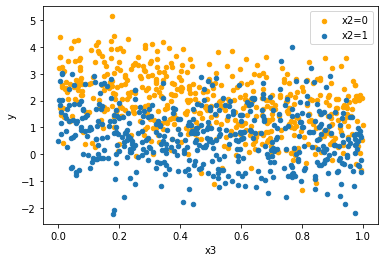

In [98]:
fig,ax = plt.subplots(); 
cs[cs.x2==0].plot.scatter(x='x3', y='y', ax=ax, label='x2=0', color='orange');
cs[cs.x2==1].plot.scatter(x='x3', y='y', ax=ax, label='x2=1');

In [99]:
# convert to numpy arrays 
y = cs['y'].values
x = cs[['x1', 'x2', 'x3']].values
x_lab = ['x1', 'x2', 'x3', 'sigma2']
y_lab = ['y']

In [100]:
la.inv((x.T@x))@(x.T@y)

array([ 2.43665583, -1.23182054, -1.07772427])

In [101]:
N,K = x.shape

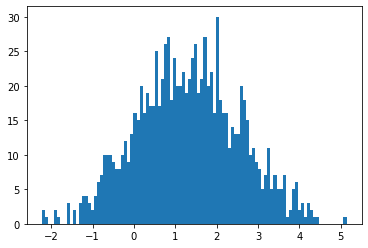

In [102]:
plt.hist(y, bins=100);

# Question 3. Using the cross section provided, estimate the model parameters for the two specifications of $h$ and compare them. Determine which $h$ was used to generate the data

In [103]:
# Find some starting values 
# OLS starting values:
theta0 = lm_exp.starting_values(y, x)
#theta0 = np.ones((K+1))

Estimated parameters of exp

In [104]:
results_exp = est.estimate(lm_exp.q, theta0, y, x)
exp_tab = est.print_table(x_lab, results_exp, title=f'h(z)=exp(-z), y = {y_lab}')
exp_tab

Optimization terminated successfully.
         Current function value: 0.515333
         Iterations: 23
         Function evaluations: 145
         Gradient evaluations: 29
Optimizer succeded after 23 iter. (145 func. evals.). Final criterion:   0.5153.
h(z)=exp(-z), y = ['y']


,theta,se,t
x1,-1.0229,0.0377,-27.1515
x2,1.0371,0.0707,14.6696
x3,0.8234,0.0828,9.9476
sigma2,1.0155,0.0237,42.7997


In [105]:
lm_exp.loglikelihood(theta0, y, x).mean()

-1.356160846029026

Estimated parameters of cdf

In [106]:
results_cdf = est.estimate(lm_cdf.q, theta0, y, x)
cdf_tab = est.print_table(x_lab, results_cdf, title=f'h(z)=3cdf(z), y = {y_lab}')
cdf_tab

Optimization terminated successfully.
         Current function value: 0.519761
         Iterations: 18
         Function evaluations: 110
         Gradient evaluations: 22
Optimizer succeded after 18 iter. (110 func. evals.). Final criterion:   0.5198.
h(z)=3cdf(z), y = ['y']


,theta,se,t
x1,0.9192,0.0797,11.5347
x2,-1.1848,0.0720,-16.4460
x3,-1.1459,0.1240,-9.2383
sigma2,1.0200,0.0235,43.3347


In [118]:
print(pd.DataFrame(cdf_tab).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &   theta &      se &        t \\
\midrule
x1     &  0.9192 &  0.0797 &  11.5347 \\
x2     & -1.1848 &  0.0720 & -16.4460 \\
x3     & -1.1459 &  0.1240 &  -9.2383 \\
sigma2 &  1.0200 &  0.0235 &  43.3347 \\
\bottomrule
\end{tabular}



In [107]:
lm_cdf.loglikelihood( theta0, y, x).mean()

-1.3429812556796963

# Question 4. Using $h(z)=\text{exp}(-(x\beta))$, estimate and report the average partial effects (APEs) on $E[y \mid x_i = x^0]$ at $x^0=(1,1,x_3)$ for each value $x_3 = 0,.1,.2,...,1$ based on the model in addition to standard errors hereof

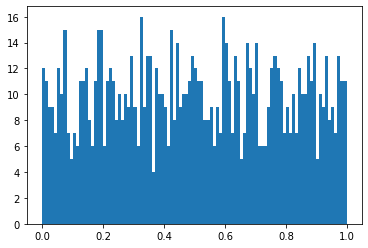

In [27]:
plt.hist(x[:,2], bins=100);

X^0 = (1,1,x_3)

In [108]:
# Using OLS starting values. Should we estimate these in each iteration?
def APE_cont(theta0,y,x):
    # copy of x observations
    x0 = x.copy()
    # x0 = (1,1,x_3)
    x0[:,0] = 1
    x0[:,1] = 1
    
    # Estimate on x
    results_boot = est.estimate(lm_cdf.q, theta0, y, x0)
    
    # estimate of theta without sigma
    thetahat_boot = results_boot['theta'][:-1]
    # Estimate of x_3
    thetahat_k_boot = results_boot['theta'][2]
    
    # Compute Average partial effect
    APE_boot = 3 * thetahat_k_boot * norm.pdf(x0@thetahat_boot).mean()
    
    return APE_boot

In [109]:
APE_cont(theta0,y,x)

Optimization terminated successfully.
         Current function value: 0.677670
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 13


-1.081562488348395

Function for bootstrap sample

In [110]:
# From exercise:
def bootstrap_sample(y,x): 
    N = y.shape[0]
    
    ii_boot = np.random.choice(range(N), N, replace=True) # vector of indices for rows 
    y_i = y[ii_boot]
    x_i = x[ii_boot] 
    
    return y_i, x_i 

Initialize bootstrap

In [111]:
# From exercise
nboot = 1000  # Number of bootstraps, should ideally be very large 

# Set already set

# initialize 
APE = np.empty((nboot,1))

for i in range(nboot): 
    print(f'Bootstrap iteration {i+1}/{nboot}')
    
    # 1. draw sample from data 
    y_i, x_i = bootstrap_sample(y,x)
    
    # 2. estimate and compute 
    APE_1 = APE_cont(theta0,y_i,x_i) 
    
    # save for each iteration
    APE [i] = APE_1

Bootstrap iteration 1/1000
Optimization terminated successfully.
         Current function value: 0.642927
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 13
Bootstrap iteration 2/1000
Optimization terminated successfully.
         Current function value: 0.653629
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 13
Bootstrap iteration 3/1000
Optimization terminated successfully.
         Current function value: 0.643908
         Iterations: 13
         Function evaluations: 70
         Gradient evaluations: 14
Bootstrap iteration 4/1000
Optimization terminated successfully.
         Current function value: 0.678253
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 12
Bootstrap iteration 5/1000
Optimization terminated successfully.
         Current function value: 0.707994
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 13
Boots

C:\Users\MBJ\OneDrive\JØ\Advanced Microeconometrics\Git_eksamen\Exam\estimation.py:125: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov))



         Current function value: 0.690224
         Iterations: 13
         Function evaluations: 70
         Gradient evaluations: 14
Bootstrap iteration 12/1000
Optimization terminated successfully.
         Current function value: 0.692326
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 12
Bootstrap iteration 13/1000
Optimization terminated successfully.
         Current function value: 0.669963
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 13
Bootstrap iteration 14/1000
Optimization terminated successfully.
         Current function value: 0.690963
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 12
Bootstrap iteration 15/1000
Optimization terminated successfully.
         Current function value: 0.669033
         Iterations: 13
         Function evaluations: 70
         Gradient evaluations: 14
Bootstrap iteration 16/1000
Optimization terminated successfully.

Table with bootstrap

In [112]:
# From exercise
ape_label = ['APE x_3']
def me_table(me: np.ndarray): 
    assert me.ndim == 2 
    n_boot,J = me.shape 
    
    m = me.mean(0)
    se = me.std(0)
    tab = pd.DataFrame({
                  'Mean m.e.': m, 
                  '-1.96 se':  m-se*1.96,
                  '+1.96 se':  m+se*1.96
                 },
                index=ape_label)
    return tab 

In [113]:
me_table(APE).round(4)

,Mean m.e.,-1.96 se,+1.96 se
APE x_3,-1.0846,-1.3349,-0.8343


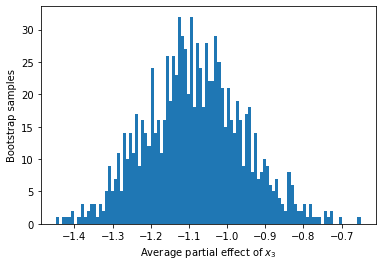

In [131]:
plt.hist(APE, bins=100); 
plt.xlabel(f'Average partial effect of $x_3$'); 
plt.ylabel('Bootstrap samples'); 

# Panel data
Cannot use Fixed effects in nonlinear models
Unobserved effects

# Panel dataset

This dataset contains $N=100$ individuals observed for $T = 10$ periods. In addition to the variables `y`, `x1`, `x2`, `x3`, this dataset also contains the variable `i` (denoting individuals), and `t` (denoting time). You do not need to use `i` and `t` in your code; it is included to help make clear the panel structure and the sorting of the dataset.  

In [35]:
p = pd.read_csv('panel.csv')
p.head(12)

,i,t,y,x1,x2,x3
0,0,0,1.179576,1.0,1.0,0.087482
1,0,1,1.247117,1.0,1.0,0.227310
2,0,2,2.031343,1.0,0.0,0.314377
3,0,3,1.914893,1.0,0.0,0.174766
4,0,4,0.109162,1.0,1.0,0.607094
5,0,5,0.683711,1.0,1.0,0.413586
6,0,6,0.648328,1.0,1.0,0.816352
7,0,7,0.597955,1.0,1.0,0.185130
8,0,8,0.784681,1.0,1.0,0.701877
9,0,9,1.974238,1.0,0.0,0.240356


Let us have a very raw look at the data, splitting on the binary variable and plotting over the continuous. 

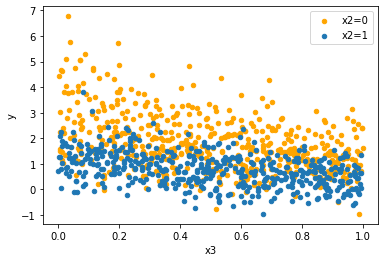

In [36]:
fig,ax = plt.subplots(); 
p[p.x2==0].plot.scatter(x='x3', y='y', ax=ax, label='x2=0', color='orange');
p[p.x2==1].plot.scatter(x='x3', y='y', ax=ax, label='x2=1');

Note that the dataset is sorted in such a way that when we use `.reshape(N,T)` on a column, we get that each row contains the $T$ observations belonging to that individual. 

In [37]:
N = p['i'].nunique() # no. unique values of personal identifier 
T = p['t'].nunique() # no. unique values of tim 
x_vars = ['x1', 'x2', 'x3']
K = len(x_vars)

# extract as numpy objects 
y = p['y'].values.reshape(N,T) # (N,T) array 
x = p[x_vars].values.reshape(N,T,K) # (N,T,K) array 

# depending on your coding preferences, you may choose to work 
# with the data in "tall" N*T arrays; here is how: 
# y = y.reshape(N*T, )
# x = x.reshape(N*T, K)

# Question 7. Using the cross section provided, estimate the model parameters for the two specifications of $h$ and compare them. Determine which $h$ was used to generate the data

Starting values, theta0

In [38]:
theta0_panel = np.ones((K+2))

In [39]:
x_lab_panel = ['x1', 'x2','x3', 'sigma_c', 'sigma_e']
y_lab = ['y']

For $h(z) = \text{exp}(-(z))$

In [90]:
R=200
q = lambda theta,y,x : sml.q_exp(theta, y, x, R=R, seed=None) # seed=None: use equiprobably grid points on (0;1)
res_exp = est.estimate(q, theta0_panel, y, x)

Optimization terminated successfully.
         Current function value: 8.909987
         Iterations: 19
         Function evaluations: 144
         Gradient evaluations: 24


In [91]:
exp_tab_panel = est.print_table(x_lab_panel, res_exp, title=f'panel: h(z)=exp(-(z)), y = {y_lab}')
exp_tab_panel

Optimizer succeded after 19 iter. (144 func. evals.). Final criterion:     8.91.
panel: h(z)=exp(-(z)), y = ['y']


,theta,se,t
x1,-0.9117,0.0517,-17.6307
x2,0.8847,0.0368,24.0692
x3,0.8906,0.0418,21.3003
sigma_c,0.5150,0.0133,38.6358
sigma_e,0.4580,0.0477,9.5976


In [92]:
sml.loglikelihood_exp(theta0_panel, y, x, R=R, seed=None).mean()

-13.537730515197737

For $h(z) = 3 \Phi(z)$

In [93]:
R=200
q = lambda theta,y,x : sml.q_cdf(theta, y, x, R=R, seed=None) # seed=None: use equiprobably grid points on (0;1)
res_cdf = est.estimate(q, theta0_panel, y, x)

Optimization terminated successfully.
         Current function value: 10.610242
         Iterations: 23
         Function evaluations: 186
         Gradient evaluations: 31


In [94]:
cdf_tab_panel = est.print_table(x_lab_panel, res_cdf, title=f'panel: h(z)=3cdf(z), y = {y_lab}')
cdf_tab_panel

Optimizer succeded after 23 iter. (186 func. evals.). Final criterion:    10.61.
panel: h(z)=3cdf(z), y = ['y']


,theta,se,t
x1,0.8082,0.0759,10.6554
x2,-1.1108,0.0646,-17.1995
x3,-1.1923,0.0901,-13.2301
sigma_c,0.6061,0.0135,44.9249
sigma_e,0.5613,0.0758,7.4019


In [95]:
sml.loglikelihood_cdf(theta0_panel, y, x, R=R, seed=None).mean()

-20.064732349709026

This time, we choose exp(-z)

# Question 8. Test the following two null hypothesis: a) $\beta_1 =  \beta_2 = \beta_3$ and b) $\beta_2 = \beta_3$

We use a wald statistic for both tests

$W = (R \hat \beta-r)'(R \hat V R')^{-1} (R \hat \beta-r)$

In [13]:
from scipy.stats import chi2

In [55]:
cov = res_exp['cov']

a)

In [78]:
r_a = np.array([0,0,0])
R_a = np.array([[0,1,-1,0,0],[1,0,-1,0,0],[1,-1,0,0,0]])

In [79]:
wald_test_a = (R_a @ res_exp['theta'] - r_a).T @ la.inv(( R_a @ cov @ R_a.T)) @ (R_a @ res_exp['theta'] - r_a)

In [139]:
wald_test_a

919.7944267870171

In [132]:
p_val_wald = chi2.sf(wald_test_a.item(), 3)

In [133]:
p_val_wald

4.502304107472956e-199

b)

In [61]:
res_exp['theta']

array([-0.91172669,  0.8847468 ,  0.89063173,  0.51498244,  0.45795892])

In [134]:
r = 0
R = np.array([0,1,-1,0,0])

In [135]:
wald_test_b = (R @ res_exp['theta'] - r).T / (R @ cov @ R.T) * (R @ res_exp['theta'] - r)

In [138]:
wald_test_b

0.012291023252532752

In [136]:
p_val_wald = chi2.sf(wald_test_b.item(), 1)

In [137]:
p_val_wald

0.9117234897270988